In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from scipy import optimize

import tensorflow as tf
import torch
import os
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import clear_output
import datetime
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
from download_daily_data import download_one_year_ohlc

In [5]:
download_one_year_ohlc()

Exception raised:  https://api.iextrading.com/1.0/stock/jwa/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/brkb/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/bfb/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/ /chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/esz8/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/lgfb/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/ubfut/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/faz8/chart/5y Expecting value: line 1 column 1 (char 0)
Exception raised:  https://api.iextrading.com/1.0/stock/bfa/chart/5y Expecting value: line 1 column 1 (char 

In [4]:
log_files = os.listdir('logs/')

In [18]:
stat_log_files = [file for file in log_files if 'stat' in file]

In [19]:
stat_log_files

['training_bce_2018-11-24_21:27:25.833460_stat_0.003.log',
 'training_bce_2018-11-24_07:44:55.533848_stat_0.003.log',
 'training_bce_2018-11-24_21:27:56.914950_stat_0.003.log',
 'training_bce_2018-11-24_21:27:04.126561_stat_0.003.log']

In [21]:
stat_log_files[2]

'training_bce_2018-11-24_21:27:56.914950_stat_0.003.log'

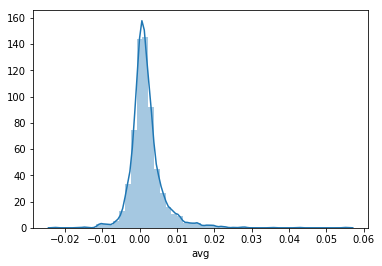

In [79]:
df = pd.read_csv('logs/'+stat_log_files[2], header=None)
df.columns = ['ticker', 'epoch', 'train_test', 'avg', 'std', 'tn_fp_fn_tp']
sns.distplot(df[(df['train_test']=='test') & (df['avg'] != 0.0)].avg)

In [95]:
temp = df[(df['train_test']=='train') & (df['avg'] != 0.0)].copy()

In [111]:
temp.groupby('ticker').agg(['mean', 'count']).head()

epoch             avg             std      
        mean count      mean count      mean count
ticker                                            
a       50.0     1  0.004670     1  0.001270     1
aa      40.0     3  0.001860     3  0.004503     3
aal     45.0     2  0.006580     2  0.009605     2
aap     32.5     4  0.003620     4  0.003735     4
aapl    30.0     5  0.010562     5  0.010196     5

In [88]:
avg_non_zero = df[(df['train_test']=='test') & (df['avg'] != 0.0)]

In [90]:
avg_non_zero.describe()

,epoch,avg,std
count,2565.000000,2565.000000,2446.000000
mean,33.824561,0.001713,0.005097
std,13.170860,0.004508,0.003992
min,10.000000,-0.022690,0.000040
25%,20.000000,-0.000500,0.002770
50%,40.000000,0.001090,0.004210
75%,50.000000,0.003130,0.006160
max,50.000000,0.055270,0.055350


In [ ]:
df.tn_fp_fn_tp = df.tn_fp_fn_tp.map(lambda x: x.split('[')[1].split(']')[0].split())

In [24]:
fig, axes = plt.subplots(len(stat_log_files), 1)

for axis, log_file in zip(axes, stat_log_files):
    df = pd.read_csv('logs/'+log_file, header=None)
    df.columns = ['ticker', 'epoch', 'train_test', 'avg', 'std', 'tn_fp_fn_tp']
    df.tn_fp_fn_tp = df.tn_fp_fn_tp.map(lambda x: x.split('[')[1].split(']')[0].split())
    sns.distplot(df[(df['train_test']=='test') & (df['avg'] != 0.0)].avg, ax=axis)

In [112]:
df.head()

,ticker,epoch,train_test,avg,std,tn_fp_fn_tp
0,clx,10,train,0.00665,0.00469,"[17486, 7, 3419, 30]"
1,clx,10,test,0.00282,NaN,"[4366, 0, 625, 1]"
2,clx,20,train,0.00856,0.00465,"[17490, 3, 3421, 28]"
3,clx,20,test,0.00292,NaN,"[4366, 0, 625, 1]"
4,clx,30,train,0.00833,0.00437,"[17490, 3, 3404, 45]"


In [126]:
df['tn'] = df.tn_fp_fn_tp.map(lambda x : int(x[0]))
df['fp'] = df.tn_fp_fn_tp.map(lambda x : int(x[1]))
df['fn'] = df.tn_fp_fn_tp.map(lambda x : int(x[2]))
df['tp'] = df.tn_fp_fn_tp.map(lambda x : int(x[3]))
df['fp_tp_avg'] = df.avg * (df.fp + df.tp)

In [129]:
df.head()

,ticker,epoch,train_test,avg,std,tn_fp_fn_tp,tn,fp,fn,tp,fp_tp_avg
0,clx,10,train,0.00665,0.00469,"[17486, 7, 3419, 30]",17486,7,3419,30,0.24605
1,clx,10,test,0.00282,NaN,"[4366, 0, 625, 1]",4366,0,625,1,0.00282
2,clx,20,train,0.00856,0.00465,"[17490, 3, 3421, 28]",17490,3,3421,28,0.26536
3,clx,20,test,0.00292,NaN,"[4366, 0, 625, 1]",4366,0,625,1,0.00292
4,clx,30,train,0.00833,0.00437,"[17490, 3, 3404, 45]",17490,3,3404,45,0.39984


1043

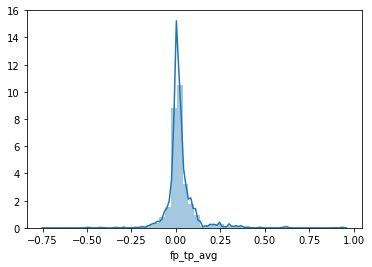

In [174]:
of_interest = df[(df['train_test']=='test') & (df['avg'] != 0.0) & (df['epoch'] < 35)
               & (df['fp'] + df['tp'] < 50)]

_ = sns.distplot(of_interest.fp_tp_avg)
len(of_interest)

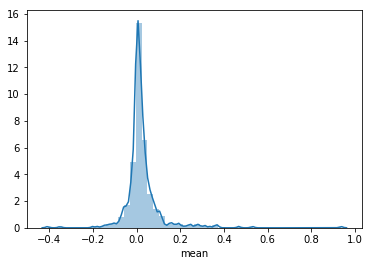

In [175]:
sns.distplot(of_interest.groupby('ticker').fp_tp_avg.agg(['mean'])['mean'])

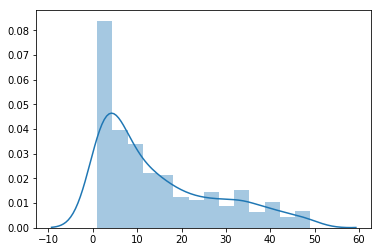

In [176]:
sns.distplot(of_interest.fp + of_interest.tp)

225

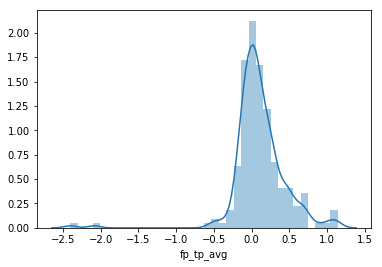

In [177]:
of_interest = df[(df['train_test']=='test') & (df['avg'] != 0.0) & (df['epoch'] < 35)
               & (df['fp'] + df['tp'] > 50)]

sns.distplot(of_interest.fp_tp_avg)
len(of_interest)

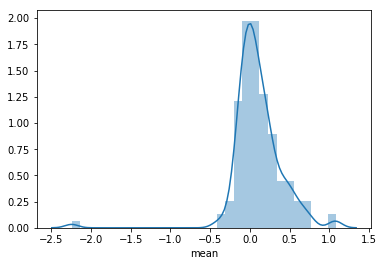

In [178]:
sns.distplot(of_interest.groupby('ticker').fp_tp_avg.agg(['mean'])['mean'])